# homework 9 CS 498

__Mean field inference for binary images__ The MNIST dataset consists of 60, 000 images of handwritten digits, curated by Yann LeCun, Corinna Cortes, and Chris Burges. You can find it [here](http://yann.lecun.com/exdb/mnist/), together with a collection of statistics on recognition, etc. We will use the first 500 of the training set images.


Obtain the MNIST training set, and binarize the first 500 images by mapping any value below .5 to -1 and any value above to 1. For each image, create a noisy version by randomly flipping 2% of the bits.
Now denoise each image using a Boltzmann machine model and mean field inference. Use $theta_{ij}=0.2$ for the $H_i$, $H_j$ terms and $theta_{ij}=0.2$ for the $H_i$,$X_j$ terms. To hand in: Report the fraction of all pixels that are correct in the 500 images.

__To hand__  and in: Prepare a figure showing the original image, the noisy image, and the reconstruction for
your most accurate reconstruction
your least accurate reconstruction
Assume that theta_{ij} for the $H_i, H_j$ terms takes a constant value c. We will investigate the effect of different values of c on the performance of the denoising algorithm. Think of your algorithm as a device that accepts an image, and for each pixel, predicts 1 or -1. You can evaluate this in the same way we evaluate a binary classifier, because you know the right value of each pixel. A receiver operating curve is a curve plotting the true positive rate against the false positive rate for a predictor, for different values of some useful parameter. We will use c as our parameter. To hand in: Using c=(-1, 0, 0.2, 1, 2) plot a receiver operating curve for your denoising algorithm.

In [135]:
import numpy as np
import os
from sklearn.metrics import roc_curve, auc
from scipy.interpolate import interp1d

from random import randint
from math import ceil
import matplotlib.pyplot as plt
import time
import pandas as pd
from sklearn.metrics import confusion_matrix

In [136]:
path = '/Users/zhoukewei/Downloads/MNIST'

#os.path.join(File_dir,'')
file_list = os.listdir(path)
#X, y = loadlocal_mnist(
#        images_path=os.path.join(path,file_list[0]), 
 #       labels_path=os.path.join(path,file_list[0])[1])

In [137]:
os.listdir(path)

['train-images-idx3-ubyte', 'train-labels-idx1-ubyte']

In [138]:
# create the function to read in the MNIST
def loadMNIST( prefix, folder ):
    intType = np.dtype( 'int32' ).newbyteorder( '>' )
    nMetaDataBytes = 4 * intType.itemsize

    data = np.fromfile( folder + "/" + prefix + '-images-idx3-ubyte', dtype = 'ubyte' )
    magicBytes, nImages, width, height = np.frombuffer( data[:nMetaDataBytes].tobytes(), intType )
    data = data[nMetaDataBytes:].astype( dtype = 'float32' ).reshape( [ nImages, width, height ] )

    labels = np.fromfile( folder + "/" + prefix + '-labels-idx1-ubyte', dtype = 'ubyte' ) \
    [2 * intType.itemsize:]

    return data, labels

trainingImages, trainingLabels = loadMNIST( "train", path)

#keep first500 
trainingImages = trainingImages[:500,:,:]
trainingLabels = trainingLabels[:500]
#binary the elements
def myfunc(a):
    if a >0.5*255:
        return(1)
    else: return(-1)
vfunc = np.vectorize(myfunc)
trainingImages_binary = vfunc(trainingImages[:,:,:] ) 
trainingImages_binary_noise = trainingImages_binary.copy()


flip_size = ceil(28*28*0.02)
for i in range(500):
    sample = np.random.choice([True, False], (28, 28),p = [0.02,0.98])
    trainingImages_binary_noise[i,sample]*=-1

#sampleImages_binary =trainingImages_binary[0]
#sampleImages_binary_noise = trainingImages_binary_noise[0]
#sampleImages = trainingImages[0]

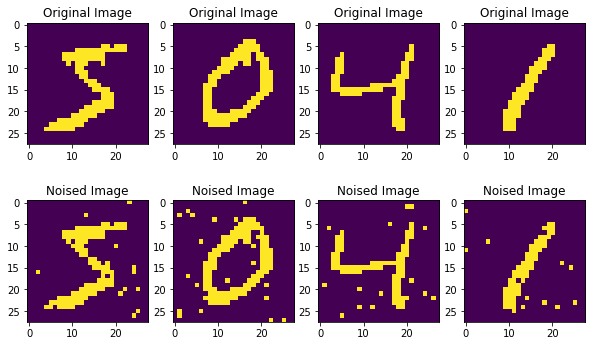

In [139]:
#sample image
#fig, axs = plt.subplots(2,4, figsize=(6, 6))
plt.figure(figsize=(10,6)) 
for i in range(4):
    plt.subplot(2,4,(i+1))
    plt.imshow( trainingImages_binary[i])
    plt.title("Original Image")
    plt.subplot(2,4,(i+5))
    plt.imshow(    trainingImages_binary_noise[i])
    plt.title("Noised Image")


using a Boltzmann machine model and mean field inference

In [140]:
#find the neighbour
def neighbor(i,j):
    i_b = i-1
    i_f = i+1
    j_b = j-1
    j_f = j+1 
    i_list = []
    j_list = []
    if i_b>-1:
        i_list.append(i_b)
    if i_f<28:
        i_list.append(i_f)
    if j_b>-1:
        j_list.append(j_b)
    if j_f<28:
        j_list.append(j_f)
    neighbor_list = []
    for i_tmp in i_list:
        neighbor_list.append((i_tmp,j))
    for j_tmp in j_list:
        neighbor_list.append((i,j_tmp))
                             
    return(neighbor_list)
     




In [141]:
# Mean feild inference
Pi = np.ones((28,28))/2
def pi_update_func(sampleImages,Pi,i,j,theta):
    denominator_1 = +0.2*sampleImages[i,j]
    denominator_2 = +-0.2*sampleImages[i,j]
    neigh = neighbor(i,j) 
    for c in range(len(neigh)):
        denominator_1 += (theta*(2*Pi[neigh[c]]-1))
        denominator_2 += (-theta*(2*Pi[neigh[c]]-1))

 #   denominator_1 = (theta*(2*Pi[neigh]-1)+0.2*sampleImages[i,j]).sum()
  #  denominator_2 = (-theta*(2*Pi[neigh]-1)+-0.2*sampleImages[i,j]).sum()

    pi_updated = 1/(1+np.exp(denominator_2-denominator_1))
    return(pi_updated)

def MFE(sampleImages,Pi,theta=0.2,itertime =100,threshold = pow(10,-6),report = False):

    for c in range(itertime):
        Pi_tmp = Pi.copy()
        for i in range(sampleImages.shape[0]):
            for j in range(sampleImages.shape[1]):
                Pi[i,j] = pi_update_func(sampleImages,Pi,i,j,theta)
        if np.sum((Pi_tmp-Pi)**2)<threshold:
            if report == True:
                print('Coverge! and iteration times = %d' %(c))
            break
    if np.sum((Pi_tmp-Pi)**2)>threshold:
        if report == True:
            print('Not coverge under threshold = %d and iteration times = %d' %(threshold,c))
    return(Pi)
            
#sampleImages_binary =trainingImages_binary[0]
#sampleImages_binary_noise = trainingImages_binary_noise[0]
#sampleImages = trainingImages[0]
#Pi_up =  MFE(sampleImages_binary ,Pi,theta=0.2,itertime =100,threshold = pow(10,-10))
#Pi_up[Pi_up>0.5]=1    
#Pi_up[Pi_up<0.5]=-1
#(sampleImages_binary==Pi_up).mean()
#Pi_up

In [142]:
def eval_ml(theta=0.2):
    Pi = np.ones((28,28))/2
    Accu_list = np.array([])    
    TPR_list = np.array([])
    FPR_list = np.array([])

    # iteration to do the BOTZman machine on the images
    for ind in range(500):
        Pi = np.ones((28,28))/2
        
        sampleImages_binary =trainingImages_binary[ind]
        sampleImages_binary_noise = trainingImages_binary_noise[ind]
        sampleImages = trainingImages[ind]
        Pi_up =  MFE(sampleImages_binary_noise ,Pi,theta,itertime =50,threshold = pow(10,-7))
        Pi_up[Pi_up>0.5]=1    
        Pi_up[Pi_up<=0.5]=-1

        
        cnf_matrix = confusion_matrix(sampleImages_binary.ravel(), Pi_up.ravel(),labels=[-1,1])
        TN, FP, FN, TP = cnf_matrix.ravel()
        TPR = TP/(TP+FN)
        FPR = FP/(FP+TN) 
        TPR_list = np.append(TPR_list,TPR)        
        FPR_list = np.append(FPR_list,FPR)
        Accu_list = np.append(Accu_list,((sampleImages_binary==Pi_up).mean()))
    Accu = Accu_list.mean() 
    fpr = FPR_list.mean()
    tpr = TPR_list.mean()
    best_ind = np.argmax(Accu_list)
    worst_ind = np.argmin(Accu_list)
    return Accu,tpr,fpr,best_ind,worst_ind 



In [143]:
s = time.time()
Accu_list = np.array([]) 
TPR_list = np.array([])
FPR_list = np.array([])
best_list = np.array([])
worst_list = np.array([])
for theta in np.array((-1, 0, 0.2, 1, 2)):
    accu,tpr,fpr,best_ind,worst_ind  = eval_ml(theta)
    best_list =  np.append(best_list,best_ind)
    worst_list =  np.append(worst_list,worst_ind)
    Accu_list = np.append(Accu_list,accu)
    TPR_list = np.append(TPR_list,tpr)        
    FPR_list = np.append(FPR_list,fpr)
c = np.array((-1, 0, 0.2, 1, 2))

e = time.time()
data = pd.DataFrame({'theta': c,'Accu': Accu_list,'TPR':TPR_list,'FPR':FPR_list})
e-s

224.00855326652527

The following table shows the performance of the model according to different theta.

In [144]:
data

,Accu,FPR,TPR,theta
0,0.501663,0.498753,0.504127,-1.0
1,0.979880,0.020000,0.978807,0.0
2,0.994247,0.002897,0.970412,0.2
3,0.872653,0.000000,0.000000,1.0
4,0.867584,0.007352,0.010314,2.0


In [1]:
!pip install scikit-optimize

    100% |████████████████████████████████| 81kB 1.9MB/s ta 0:00:011
You are using pip version 18.0, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


From the table we know the best theta = 0 ,the worst theta =  -1

No handles with labels found to put in legend.


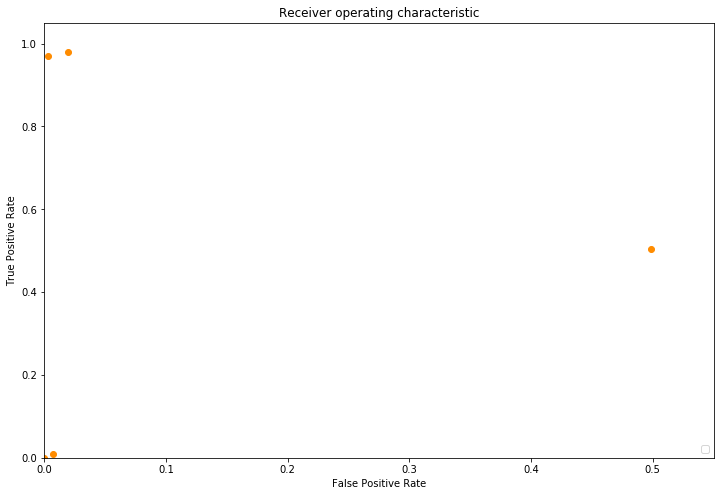

In [145]:
TPR_list = np.append(TPR_list,[])        
FPR_list = np.append(FPR_list,[])
fpr_new = np.linspace(FPR_list.min(), FPR_list.max(),50)

f = interp1d((FPR_list),(TPR_list),kind= 'slinear')
tpr_smooth=f(fpr_new)

plt.figure(figsize=(12,8))

plt.scatter((FPR_list),(TPR_list),color='darkorange')

plt.xlim([0.0, 0.55])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Prepare a figure showing the original image, the noisy image, and the reconstruction for
your most accurate reconstruction
your least accurate reconstruction

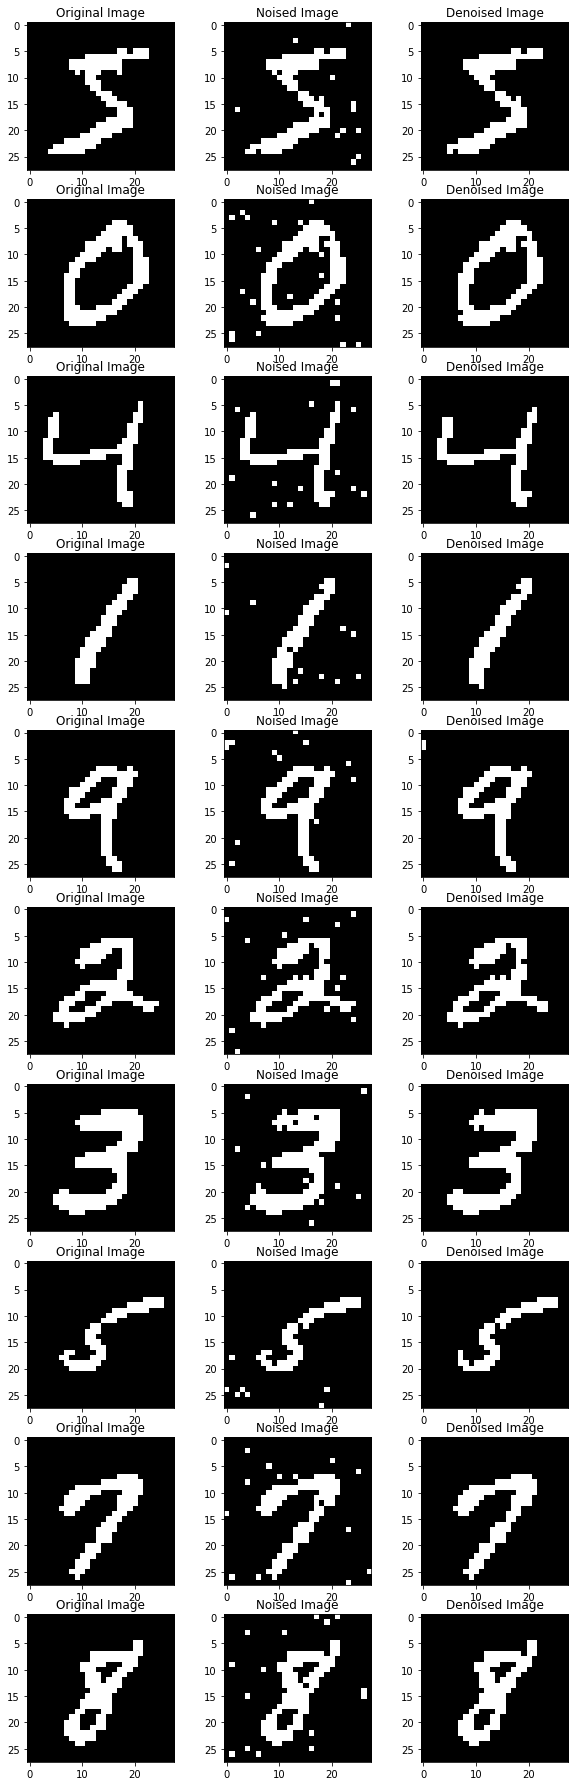

In [148]:
plt.figure(figsize=(10,32))

ind = [0,1,2,3,4,5,7,11,15,17]
c =0
for i in ind:
    sampleImages_binary =trainingImages_binary[i]
    sampleImages_binary_noise = trainingImages_binary_noise[i]
    sampleImages = trainingImages[i]
    Pi_up =  MFE(sampleImages_binary_noise ,Pi,theta=0.2,itertime =100,threshold = pow(10,-10))
    Pi_up[Pi_up>0.5]=1    
    Pi_up[Pi_up<0.5]=-1

    plt.subplot(10,3,(c*3+1))
    plt.imshow(sampleImages_binary,cmap = 'gray') 
    plt.title("Original Image")

    plt.subplot(10,3,(c*3+2))

    plt.imshow(sampleImages_binary_noise,cmap = 'gray')
    plt.title("Noised Image")

    plt.subplot(10,3,(c*3+3))
\
    plt.imshow(Pi_up,cmap = 'gray')
    plt.title("Denoised Image")
    c= c+1

 

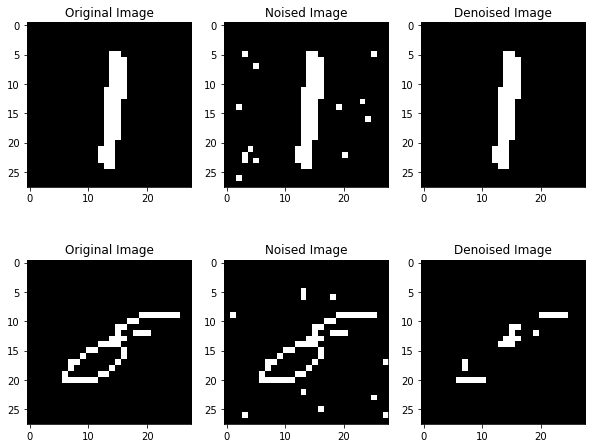

In [157]:
plt.figure(figsize=(10,8))
#see the best picture/worst picture under theta =0.2
ind = [ int(best_list[2]),int(worst_list[2])]
c =0
for i in ind:
    sampleImages_binary =trainingImages_binary[i]
    sampleImages_binary_noise = trainingImages_binary_noise[i]
    sampleImages = trainingImages[i]
    Pi_up =  MFE(sampleImages_binary_noise ,Pi,theta=0.2,itertime =100,threshold = pow(10,-10))
    Pi_up[Pi_up>0.5]=1    
    Pi_up[Pi_up<0.5]=-1

    plt.subplot(2,3,(c*3+1))
    plt.imshow(sampleImages_binary,cmap = 'gray') 
    plt.title("Original Image")

    plt.subplot(2,3,(c*3+2))

    plt.imshow(sampleImages_binary_noise,cmap = 'gray')
    plt.title("Noised Image")

    plt.subplot(2,3,(c*3+3))
\
    plt.imshow(Pi_up,cmap = 'gray')
    plt.title("Denoised Image")
    c= c+1

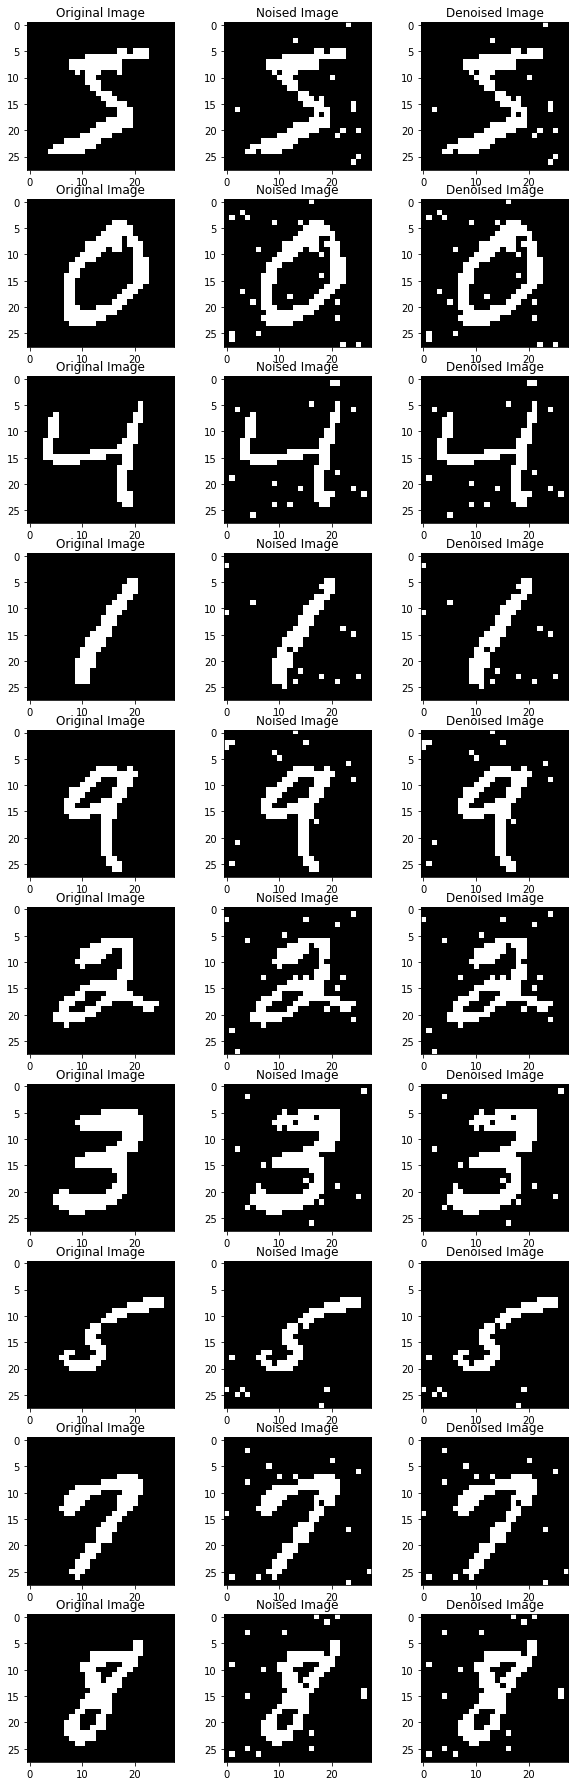

In [158]:
plt.figure(figsize=(10,32))

ind = [0,1,2,3,4,5,7,11,15,17]
c =0
for i in ind:
    sampleImages_binary =trainingImages_binary[i]
    sampleImages_binary_noise = trainingImages_binary_noise[i]
    sampleImages = trainingImages[i]
    Pi_up =  MFE(sampleImages_binary_noise ,Pi,theta=0,itertime =100,threshold = pow(10,-10))
    Pi_up[Pi_up>0.5]=1    
    Pi_up[Pi_up<0.5]=-1

    plt.subplot(10,3,(c*3+1))
    plt.imshow(sampleImages_binary,cmap = 'gray') 
    plt.title("Original Image")

    plt.subplot(10,3,(c*3+2))

    plt.imshow(sampleImages_binary_noise,cmap = 'gray')
    plt.title("Noised Image")

    plt.subplot(10,3,(c*3+3))
\
    plt.imshow(Pi_up,cmap = 'gray')
    plt.title("Denoised Image")
    c= c+1

 